# Intel Image Classification – Full Pipeline (Single File)
Run end-to-end: EDA → Train (SmallCNN / MobileNetV2 / ResNet18) → Evaluate → Compare → Inference demo.

## Requirements
- Dataset folders:
  - data/intel/seg_train/<class folders>
  - data/intel/seg_test/<class folders>
- Python 3.11 env (.venv311), PyTorch + CUDA (khuyến nghị)

## How to use
1) Set MODEL or TRAIN_ALL=True in the Config cell.
2) Run cells top-to-bottom.

In [1]:
# ===== Imports & Basic Checks =====
import os, random, csv, datetime as dt
from pathlib import Path
from typing import List, Tuple, Optional

import numpy as np
import matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
)

print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

Torch: 2.5.1+cu121 | CUDA available: True
CUDA device: NVIDIA GeForce GTX 1650 Ti


In [21]:
# ===== Config =====
DATA_ROOT = "../data/intel"
IMG_SIZE  = 160
BATCH_SIZE = 64
NUM_WORKERS = 2

# Train schedule
EPOCHS_SMALLCNN = 10
EPOCHS_HEAD = 8     # head-only for transfer learning models
EPOCHS_FT   = 12    # fine-tune for transfer learning models
LR_SMALLCNN = 1e-3
LR_HEAD = 1e-3
LR_FT   = 1e-4
WD = 1e-4

# Choose model OR train all
MODEL = "smallcnn"      # smallcnn | mobilenetv2 | resnet18
TRAIN_ALL = True          # True: train all three models sequentially

# Optional tag for run folders (if empty, timestamp is used)
RUN_TAG = ""               # e.g. "run1" / "head_only", etc.

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

set_seed(42)

assert os.path.isdir(os.path.join(DATA_ROOT, "seg_train")), "Missing data/intel/seg_train"
assert os.path.isdir(os.path.join(DATA_ROOT, "seg_test")),  "Missing data/intel/seg_test"

print("Using device:", DEVICE)

Using device: cuda


Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


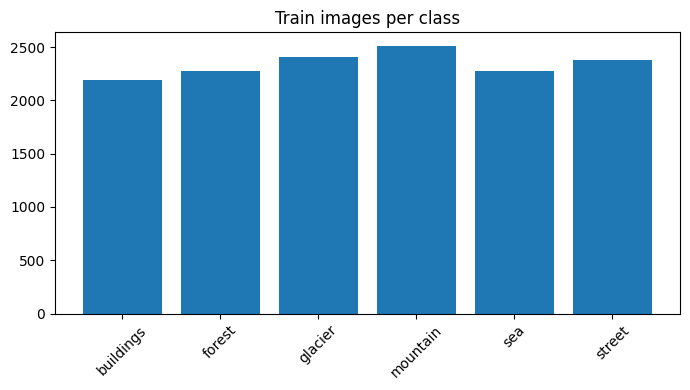

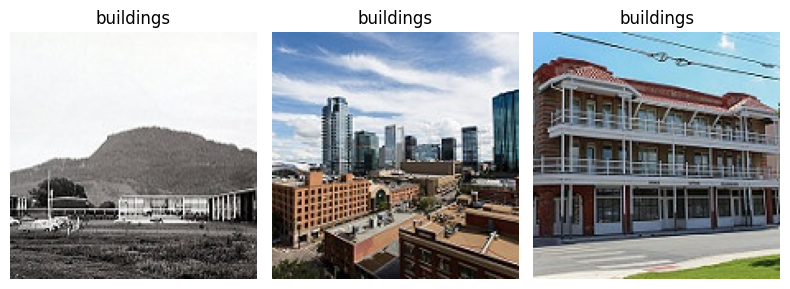

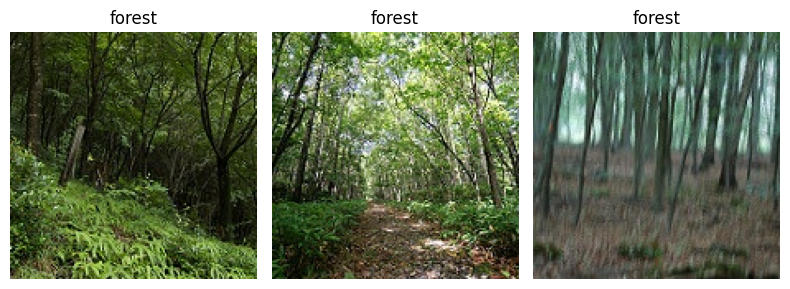

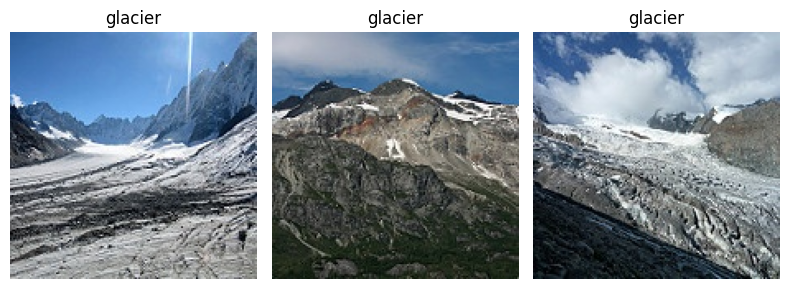

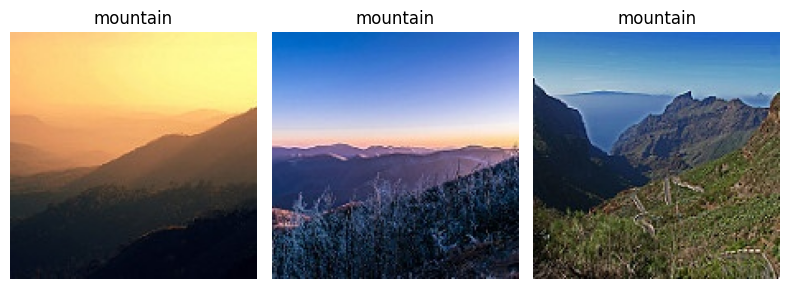

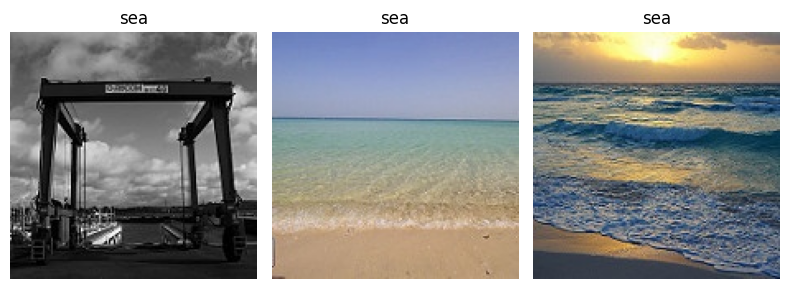

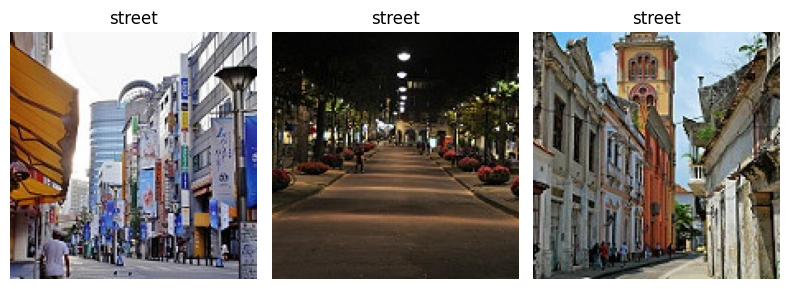

In [6]:
# ===== EDA (quick) =====
from PIL import Image

train_dir = Path(DATA_ROOT) / "seg_train"
test_dir  = Path(DATA_ROOT) / "seg_test"

classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
print("Classes:", classes)

counts = [len(list((train_dir/c).glob("*.*"))) for c in classes]
plt.figure(figsize=(7,4))
plt.bar(classes, counts)
plt.xticks(rotation=45)
plt.title("Train images per class")
plt.tight_layout()
plt.show()

# quick preview
for c in classes[:6]:
    files = list((train_dir/c).glob("*.*"))[:3]
    if not files: 
        continue
    fig, axes = plt.subplots(1, len(files), figsize=(8,3))
    for ax, p in zip(axes, files):
        ax.imshow(Image.open(p).convert("RGB"))
        ax.set_title(c); ax.axis("off")
    plt.tight_layout(); plt.show()

In [7]:
# ===== Data loaders =====
def get_loaders(data_root=DATA_ROOT, img_size=IMG_SIZE, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    tfm_train = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,)*3, (0.5,)*3),
    ])
    tfm_eval = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,)*3, (0.5,)*3),
    ])
    train_ds = datasets.ImageFolder(os.path.join(data_root, "seg_train"), transform=tfm_train)
    val_ds   = datasets.ImageFolder(os.path.join(data_root, "seg_test"),  transform=tfm_eval)
    test_ds  = val_ds

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, test_loader, train_ds.classes

In [8]:
# ===== Models =====
class SmallCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x): 
        return self.head(self.features(x))

def create_mobilenet(num_classes, pretrained=True):
    m = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1 if pretrained else None)
    in_f = m.classifier[1].in_features
    m.classifier[1] = nn.Linear(in_f, num_classes)
    return m

def create_resnet18(num_classes, pretrained=True):
    m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

In [9]:
# ===== Utils: training, evaluation, run dirs =====
def make_run_dir(base="results", model="smallcnn", freeze=False, tag=""):
    model_folder = f"{model}{'_freeze' if freeze else ''}"
    stamp = dt.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    leaf = tag.strip().replace(" ", "_") if tag else stamp
    out_dir = os.path.join(base, model_folder, leaf)
    os.makedirs(out_dir, exist_ok=True)
    return out_dir

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += x.size(0)
    return loss_sum/total, correct/total

@torch.no_grad()
def eval_epoch(model, loader, criterion, device):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        loss_sum += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += x.size(0)
    return loss_sum/total, correct/total

@torch.no_grad()
def evaluate_full(model, loader, classes, device):
    y_true, y_pred = [], []
    model.eval()
    for x,y in loader:
        x = x.to(device)
        p = model(x).argmax(1).cpu().numpy()
        y_pred.extend(p); y_true.extend(y.numpy())
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    acc = float((y_true == y_pred).mean())
    rep = classification_report(y_true, y_pred, target_names=classes, digits=3)
    cm  = confusion_matrix(y_true, y_pred)
    return acc, rep, cm

In [10]:
# ===== Train one model (handles SmallCNN / MobileNetV2 / ResNet18) =====
def train_one_model(model_name: str, run_tag: str = RUN_TAG):
    train_loader, val_loader, test_loader, classes = get_loaders()
    num_classes = len(classes)

    if model_name == "smallcnn":
        model = SmallCNN(num_classes).to(DEVICE)
        out_dir = make_run_dir(model="smallcnn", freeze=False, tag=run_tag or "baseline")
        epochs = EPOCHS_SMALLCNN
        lr = LR_SMALLCNN

        csv_path = os.path.join(out_dir, "logs.csv")
        with open(csv_path, "w", newline="", encoding="utf-8") as f:
            csv.writer(f).writerow(["epoch","tr_loss","tr_acc","val_loss","val_acc"])

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=WD)
        best_acc = 0.0

        for ep in range(1, epochs+1):
            tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion, DEVICE)
            with open(csv_path, "a", newline="", encoding="utf-8") as f:
                csv.writer(f).writerow([ep, f"{tr_loss:.6f}", f"{tr_acc:.6f}", f"{val_loss:.6f}", f"{val_acc:.6f}"])
            print(f"[SmallCNN {ep:02d}] TrainAcc {tr_acc*100:.2f}% | ValAcc {val_acc*100:.2f}%")
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save({"model": model.state_dict(), "classes": classes, "val_acc": float(best_acc)},
                           os.path.join(out_dir, "smallcnn_best.pt"))

        # test + figures
        acc, rep, cm = evaluate_full(model, test_loader, classes, DEVICE)
        with open(os.path.join(out_dir, "classification_report.txt"), "w", encoding="utf-8") as f:
            f.write(rep)

        import pandas as pd
        df = pd.read_csv(csv_path)
        plt.figure(figsize=(6,4)); plt.plot(df.epoch, df.tr_acc, label="train"); plt.plot(df.epoch, df.val_acc, label="val")
        plt.ylabel("accuracy"); plt.xlabel("epoch"); plt.legend(); plt.tight_layout()
        plt.savefig(os.path.join(out_dir, "acc_curve.png"), dpi=200); plt.show()

        plt.figure(figsize=(6,4)); plt.plot(df.epoch, df.tr_loss, label="train"); plt.plot(df.epoch, df.val_loss, label="val")
        plt.ylabel("loss"); plt.xlabel("epoch"); plt.legend(); plt.tight_layout()
        plt.savefig(os.path.join(out_dir, "loss_curve.png"), dpi=200); plt.show()

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        fig, ax = plt.subplots(figsize=(6,6))
        disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
        plt.tight_layout(); plt.savefig(os.path.join(out_dir,"confusion_matrix.png"), dpi=200); plt.show()

        return out_dir, acc

    elif model_name == "mobilenetv2":
        # head-only
        model = create_mobilenet(num_classes, pretrained=True)
        for p in model.features.parameters(): p.requires_grad = False
        model = model.to(DEVICE)

        out_dir = make_run_dir(model="mobilenetv2", freeze=True, tag=run_tag or "head_then_ft")
        csv_path = os.path.join(out_dir, "logs.csv")
        with open(csv_path, "w", newline="", encoding="utf-8") as f:
            csv.writer(f).writerow(["epoch","tr_loss","tr_acc","val_loss","val_acc"])

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_HEAD, weight_decay=WD)
        best_acc = 0.0

        for ep in range(1, EPOCHS_HEAD+1):
            tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion, DEVICE)
            with open(csv_path, "a", newline="", encoding="utf-8") as f:
                csv.writer(f).writerow([ep, f"{tr_loss:.6f}", f"{tr_acc:.6f}", f"{val_loss:.6f}", f"{val_acc:.6f}"])
            print(f"[MV2 Head {ep:02d}] TrainAcc {tr_acc*100:.2f}% | ValAcc {val_acc*100:.2f}%")
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save({"model": model.state_dict(), "classes": classes, "val_acc": float(best_acc)},
                           os.path.join(out_dir, "mobilenetv2_best.pt"))

        # fine-tune
        for name, m in list(model.features.named_children())[-3:]:
            for p in m.parameters(): p.requires_grad = True
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_FT, weight_decay=WD)

        for ep in range(1, EPOCHS_FT+1):
            tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion, DEVICE)
            with open(csv_path, "a", newline="", encoding="utf-8") as f:
                csv.writer(f).writerow([EPOCHS_HEAD+ep, f"{tr_loss:.6f}", f"{tr_acc:.6f}", f"{val_loss:.6f}", f"{val_acc:.6f}"])
            print(f"[MV2 FT   {ep:02d}] TrainAcc {tr_acc*100:.2f}% | ValAcc {val_acc*100:.2f}%")
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save({"model": model.state_dict(), "classes": classes, "val_acc": float(best_acc)},
                           os.path.join(out_dir, "mobilenetv2_best.pt"))

        # test + figures
        acc, rep, cm = evaluate_full(model, test_loader, classes, DEVICE)
        with open(os.path.join(out_dir, "classification_report.txt"), "w", encoding="utf-8") as f:
            f.write(rep)

        import pandas as pd
        df = pd.read_csv(csv_path)
        plt.figure(figsize=(6,4)); plt.plot(df.epoch, df.tr_acc, label="train"); plt.plot(df.epoch, df.val_acc, label="val")
        plt.ylabel("accuracy"); plt.xlabel("epoch"); plt.legend(); plt.tight_layout()
        plt.savefig(os.path.join(out_dir, "acc_curve.png"), dpi=200); plt.show()

        plt.figure(figsize=(6,4)); plt.plot(df.epoch, df.tr_loss, label="train"); plt.plot(df.epoch, df.val_loss, label="val")
        plt.ylabel("loss"); plt.xlabel("epoch"); plt.legend(); plt.tight_layout()
        plt.savefig(os.path.join(out_dir, "loss_curve.png"), dpi=200); plt.show()

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        fig, ax = plt.subplots(figsize=(6,6))
        disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
        plt.tight_layout(); plt.savefig(os.path.join(out_dir,"confusion_matrix.png"), dpi=200); plt.show()

        return out_dir, acc

    elif model_name == "resnet18":
        # head-only
        model = create_resnet18(num_classes, pretrained=True)
        for n,p in model.named_parameters():
            if not n.startswith("fc."):
                p.requires_grad = False
        model = model.to(DEVICE)

        out_dir = make_run_dir(model="resnet18", freeze=True, tag=run_tag or "head_then_ft")
        csv_path = os.path.join(out_dir, "logs.csv")
        with open(csv_path, "w", newline="", encoding="utf-8") as f:
            csv.writer(f).writerow(["epoch","tr_loss","tr_acc","val_loss","val_acc"])

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_HEAD, weight_decay=WD)
        best_acc = 0.0

        for ep in range(1, EPOCHS_HEAD+1):
            tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion, DEVICE)
            with open(csv_path, "a", newline="", encoding="utf-8") as f:
                csv.writer(f).writerow([ep, f"{tr_loss:.6f}", f"{tr_acc:.6f}", f"{val_loss:.6f}", f"{val_acc:.6f}"])
            print(f"[R18 Head {ep:02d}] TrainAcc {tr_acc*100:.2f}% | ValAcc {val_acc*100:.2f}%")
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save({"model": model.state_dict(), "classes": classes, "val_acc": float(best_acc)},
                           os.path.join(out_dir, "resnet18_best.pt"))

        # fine-tune
        for p in model.layer4.parameters(): 
            p.requires_grad = True
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_FT, weight_decay=WD)

        for ep in range(1, EPOCHS_FT+1):
            tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion, DEVICE)
            with open(csv_path, "a", newline="", encoding="utf-8") as f:
                csv.writer(f).writerow([EPOCHS_HEAD+ep, f"{tr_loss:.6f}", f"{tr_acc:.6f}", f"{val_loss:.6f}", f"{val_acc:.6f}"])
            print(f"[R18 FT   {ep:02d}] TrainAcc {tr_acc*100:.2f}% | ValAcc {val_acc*100:.2f}%")
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save({"model": model.state_dict(), "classes": classes, "val_acc": float(best_acc)},
                           os.path.join(out_dir, "resnet18_best.pt"))

        # test + figures
        acc, rep, cm = evaluate_full(model, test_loader, classes, DEVICE)
        with open(os.path.join(out_dir, "classification_report.txt"), "w", encoding="utf-8") as f:
            f.write(rep)

        import pandas as pd
        df = pd.read_csv(csv_path)
        plt.figure(figsize=(6,4)); plt.plot(df.epoch, df.tr_acc, label="train"); plt.plot(df.epoch, df.val_acc, label="val")
        plt.ylabel("accuracy"); plt.xlabel("epoch"); plt.legend(); plt.tight_layout()
        plt.savefig(os.path.join(out_dir, "acc_curve.png"), dpi=200); plt.show()

        plt.figure(figsize=(6,4)); plt.plot(df.epoch, df.tr_loss, label="train"); plt.plot(df.epoch, df.val_loss, label="val")
        plt.ylabel("loss"); plt.xlabel("epoch"); plt.legend(); plt.tight_layout()
        plt.savefig(os.path.join(out_dir, "loss_curve.png"), dpi=200); plt.show()

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        fig, ax = plt.subplots(figsize=(6,6))
        disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
        plt.tight_layout(); plt.savefig(os.path.join(out_dir,"confusion_matrix.png"), dpi=200); plt.show()

        return out_dir, acc

    else:
        raise ValueError("Unknown model name: " + str(model_name))


==== Training: smallcnn ====
[SmallCNN 01] TrainAcc 61.76% | ValAcc 68.40%
[SmallCNN 02] TrainAcc 72.04% | ValAcc 71.37%
[SmallCNN 03] TrainAcc 74.31% | ValAcc 66.33%
[SmallCNN 04] TrainAcc 74.96% | ValAcc 71.43%
[SmallCNN 05] TrainAcc 76.36% | ValAcc 74.10%
[SmallCNN 06] TrainAcc 77.39% | ValAcc 78.90%
[SmallCNN 07] TrainAcc 77.66% | ValAcc 79.77%
[SmallCNN 08] TrainAcc 78.40% | ValAcc 78.93%
[SmallCNN 09] TrainAcc 79.07% | ValAcc 80.13%
[SmallCNN 10] TrainAcc 79.70% | ValAcc 81.33%


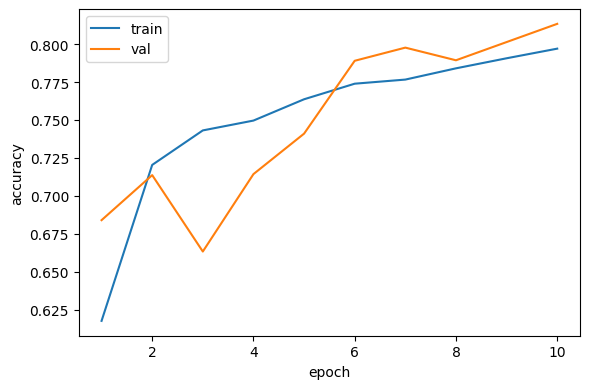

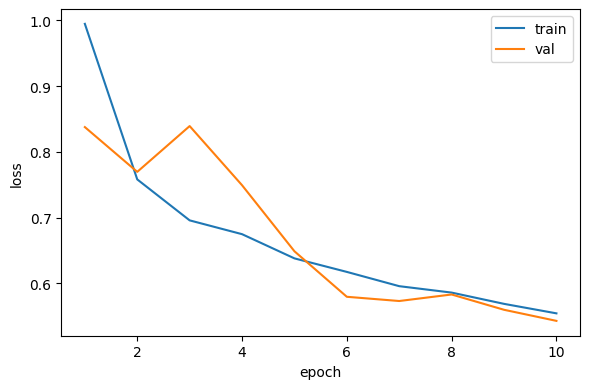

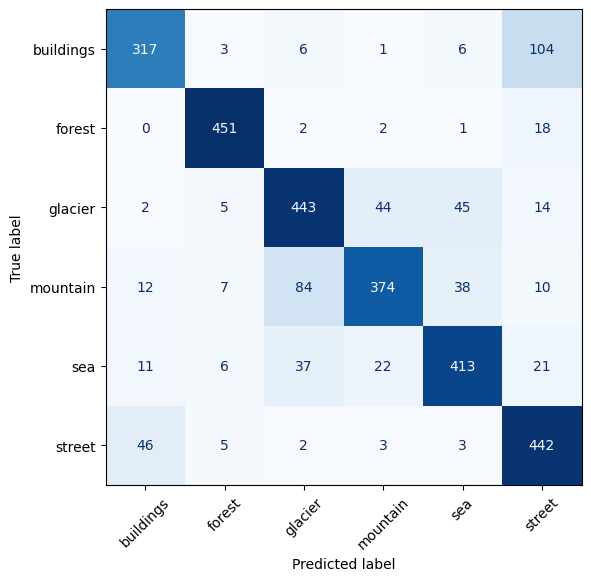


==== Training: mobilenetv2 ====
[MV2 Head 01] TrainAcc 84.62% | ValAcc 89.13%
[MV2 Head 02] TrainAcc 89.01% | ValAcc 89.83%
[MV2 Head 03] TrainAcc 89.43% | ValAcc 89.60%
[MV2 Head 04] TrainAcc 89.25% | ValAcc 90.40%
[MV2 Head 05] TrainAcc 89.77% | ValAcc 90.27%
[MV2 Head 06] TrainAcc 89.72% | ValAcc 90.23%
[MV2 Head 07] TrainAcc 90.26% | ValAcc 90.50%
[MV2 Head 08] TrainAcc 90.38% | ValAcc 90.37%
[MV2 FT   01] TrainAcc 90.68% | ValAcc 91.50%
[MV2 FT   02] TrainAcc 93.56% | ValAcc 92.33%
[MV2 FT   03] TrainAcc 95.02% | ValAcc 92.60%
[MV2 FT   04] TrainAcc 96.04% | ValAcc 92.47%
[MV2 FT   05] TrainAcc 96.82% | ValAcc 92.57%
[MV2 FT   06] TrainAcc 97.31% | ValAcc 92.23%
[MV2 FT   07] TrainAcc 97.95% | ValAcc 92.37%
[MV2 FT   08] TrainAcc 98.59% | ValAcc 92.40%
[MV2 FT   09] TrainAcc 98.60% | ValAcc 92.80%
[MV2 FT   10] TrainAcc 98.96% | ValAcc 92.70%
[MV2 FT   11] TrainAcc 99.11% | ValAcc 92.83%
[MV2 FT   12] TrainAcc 99.19% | ValAcc 92.07%


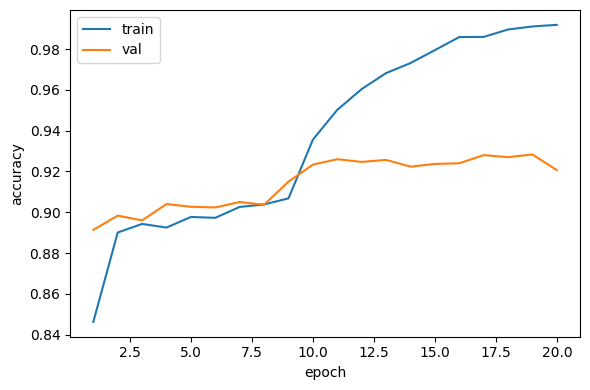

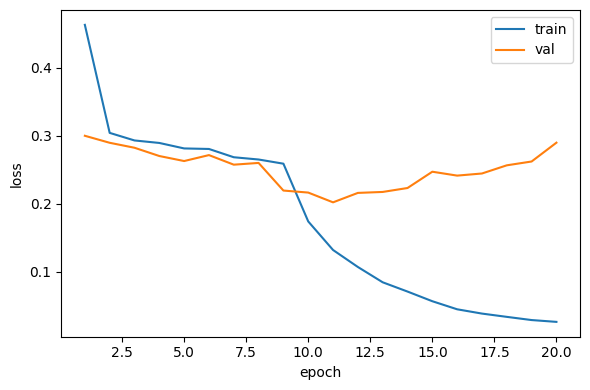

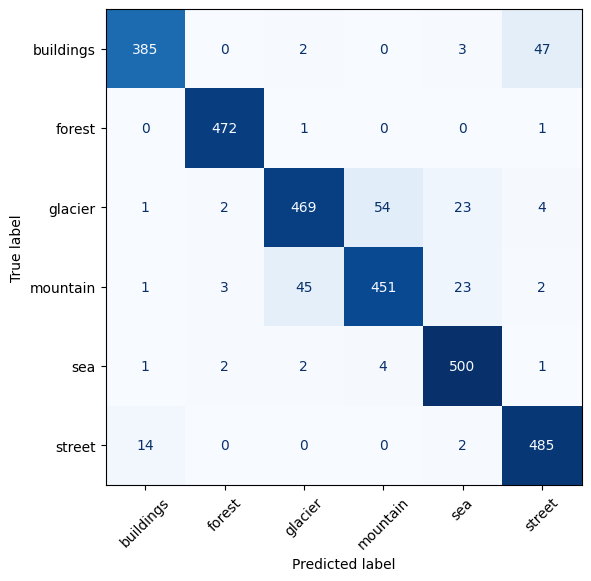


==== Training: resnet18 ====
[R18 Head 01] TrainAcc 81.54% | ValAcc 88.20%
[R18 Head 02] TrainAcc 88.30% | ValAcc 88.73%
[R18 Head 03] TrainAcc 89.08% | ValAcc 88.40%
[R18 Head 04] TrainAcc 89.24% | ValAcc 89.60%
[R18 Head 05] TrainAcc 89.54% | ValAcc 89.67%
[R18 Head 06] TrainAcc 90.32% | ValAcc 90.13%
[R18 Head 07] TrainAcc 90.02% | ValAcc 88.60%
[R18 Head 08] TrainAcc 90.54% | ValAcc 89.13%
[R18 FT   01] TrainAcc 90.85% | ValAcc 92.40%
[R18 FT   02] TrainAcc 96.13% | ValAcc 92.27%
[R18 FT   03] TrainAcc 97.92% | ValAcc 92.73%
[R18 FT   04] TrainAcc 98.69% | ValAcc 93.10%
[R18 FT   05] TrainAcc 99.02% | ValAcc 92.73%
[R18 FT   06] TrainAcc 99.34% | ValAcc 93.07%
[R18 FT   07] TrainAcc 99.66% | ValAcc 93.30%
[R18 FT   08] TrainAcc 99.59% | ValAcc 93.07%
[R18 FT   09] TrainAcc 99.68% | ValAcc 92.87%
[R18 FT   10] TrainAcc 99.65% | ValAcc 93.17%
[R18 FT   11] TrainAcc 99.52% | ValAcc 92.40%
[R18 FT   12] TrainAcc 99.55% | ValAcc 92.77%


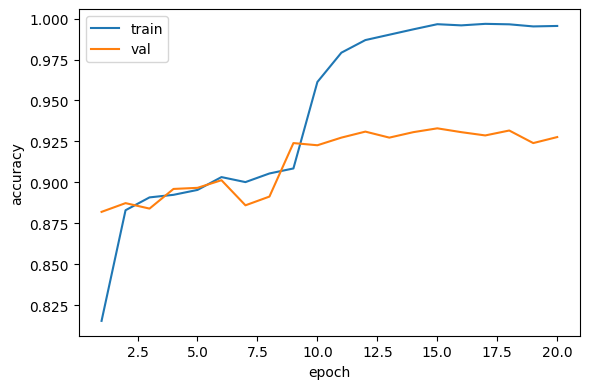

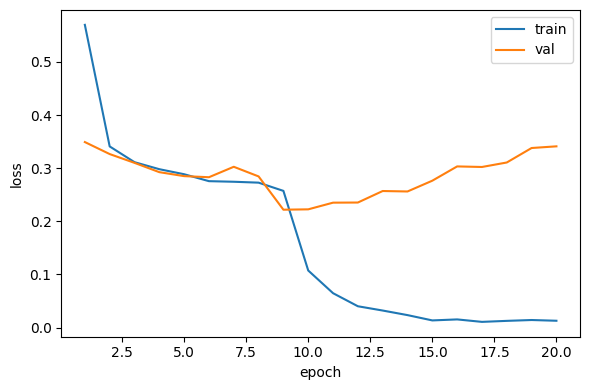

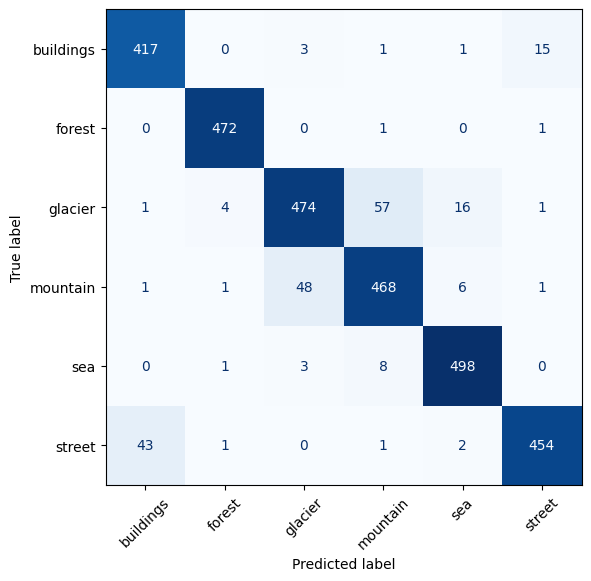


Trained summary (current session):
 - smallcnn     | out_dir=results\smallcnn\baseline | test_acc=0.8133
 - mobilenetv2  | out_dir=results\mobilenetv2_freeze\head_then_ft | test_acc=0.9207
 - resnet18     | out_dir=results\resnet18_freeze\head_then_ft | test_acc=0.9277


In [22]:
# ===== Run training =====
trained = []
if TRAIN_ALL:
    for m in ["smallcnn","mobilenetv2","resnet18"]:
        print("\n==== Training:", m, "====")
        out_dir, acc = train_one_model(m)
        trained.append((m, out_dir, acc))
else:
    out_dir, acc = train_one_model(MODEL)
    trained.append((MODEL, out_dir, acc))

print("\nTrained summary (current session):")
for m, rd, ac in trained:
    print(f" - {m:12s} | out_dir={rd} | test_acc={ac:.4f}")

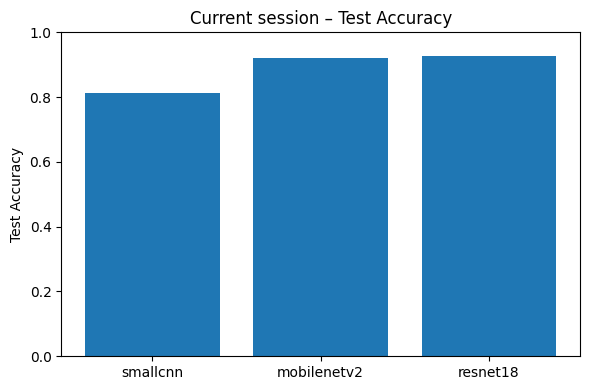

Summary updated: results/summary_eval.csv
Saved plot: results/compare_test_acc_session.png


In [33]:
# ===== Save/Append summary & plot compare (current session only) =====
os.makedirs("results", exist_ok=True)
summary_csv = "results/summary_eval.csv"
rows = [("model","run_dir","test_acc")] + [(m, rd, f"{ac:.4f}") for m, rd, ac in trained]

mode = "a" if os.path.isfile(summary_csv) else "w"
with open(summary_csv, mode, newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    if mode == "w":
        w.writerows(rows)
    else:
        for r in rows[1:]:
            w.writerow(r)

labels = [r[0] for r in trained]
test_accs = [r[2] for r in trained]

plt.figure(figsize=(6,4))
plt.bar(labels, test_accs)
plt.ylim(0,1.0)
plt.ylabel("Test Accuracy")
plt.title("Current session – Test Accuracy")
plt.tight_layout()
plt.savefig("results/compare_test_acc_session.png", dpi=200)
plt.show()

print("Summary updated:", summary_csv)
print("Saved plot:", "results/compare_test_acc_session.png")

In [32]:
# ===== Inference demo on data/intel/seg_pred (optional) =====
from PIL import Image

def infer_folder(model_ckpt_dir: str, topk: int = 3):
    # find checkpoint
    cand = [f for f in os.listdir(model_ckpt_dir) if f.endswith("_best.pt") or f=="best_model.pt"]
    if not cand:
        print("No checkpoint in:", model_ckpt_dir)
        return
    ckpt_path = os.path.join(model_ckpt_dir, cand[0])
    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
    classes = ckpt.get("classes", ['buildings','forest','glacier','mountain','sea','street'])

    # guess arch
    name = os.path.basename(ckpt_path).lower()
    if "mobilenetv2" in name:
        model = create_mobilenet(len(classes), pretrained=False)
    elif "resnet18" in name:
        model = create_resnet18(len(classes), pretrained=False)
    else:
        model = SmallCNN(len(classes))
    model.load_state_dict(state); model.to(DEVICE).eval()

    tfm = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,)*3,(0.5,)*3)
    ])

    pred_dir = os.path.join(DATA_ROOT, "seg_pred")
    if not os.path.isdir(pred_dir):
        print("No seg_pred folder found at:", pred_dir)
        return

    files = [f for f in os.listdir(pred_dir) if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.webp'))][:10]
    if not files:
        print("No images found in", pred_dir)
        return

    for nm in files:
        img = Image.open(os.path.join(pred_dir, nm)).convert("RGB")
        x = tfm(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            prob = torch.softmax(model(x), dim=1)[0]
            tv, ti = prob.topk(min(topk, len(classes)))
        display(img)
        print(nm, "→", [(classes[i], float(tv[k])) for k,i in enumerate(ti.cpu().numpy())])


C:\Users\thanh\AppData\Local\Temp\ipykernel_13864\1868347981.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=DEVICE)


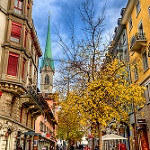

10004.jpg → [('street', 0.4798097610473633), ('buildings', 0.38911888003349304), ('forest', 0.12602661550045013)]


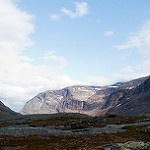

10005.jpg → [('mountain', 0.48419255018234253), ('buildings', 0.20361103117465973), ('glacier', 0.16864101588726044)]


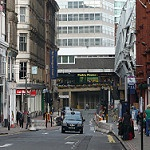

10012.jpg → [('street', 0.6583943963050842), ('buildings', 0.3415297567844391), ('forest', 7.521436782553792e-05)]


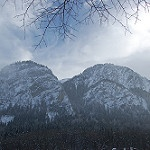

10013.jpg → [('glacier', 0.6973118185997009), ('mountain', 0.2901076376438141), ('buildings', 0.005746190436184406)]


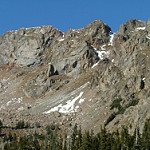

10017.jpg → [('mountain', 0.6585759520530701), ('street', 0.09577616304159164), ('glacier', 0.07435653358697891)]


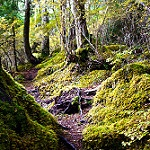

10021.jpg → [('forest', 0.9814956784248352), ('street', 0.012736674398183823), ('buildings', 0.002330027287825942)]


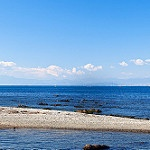

1003.jpg → [('sea', 0.9908846020698547), ('glacier', 0.0072122178971767426), ('mountain', 0.0012646133545786142)]


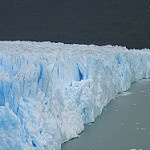

10034.jpg → [('glacier', 0.948552668094635), ('mountain', 0.025585327297449112), ('sea', 0.019172437489032745)]


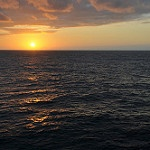

10038.jpg → [('sea', 0.7377811074256897), ('buildings', 0.17493784427642822), ('street', 0.07200246304273605)]


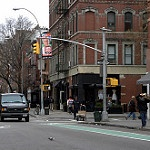

10040.jpg → [('street', 0.7589382529258728), ('buildings', 0.24104933440685272), ('sea', 7.945850484247785e-06)]
[('smallcnn', 'results\\smallcnn\\baseline', 0.8133333333333334), ('mobilenetv2', 'results\\mobilenetv2_freeze\\head_then_ft', 0.9206666666666666), ('resnet18', 'results\\resnet18_freeze\\head_then_ft', 0.9276666666666666)]


In [ ]:
infer_folder(trained[0][1]) # infer on the first trained model

In [30]:
print(trained)

[('smallcnn', 'results\\smallcnn\\baseline', 0.8133333333333334), ('mobilenetv2', 'results\\mobilenetv2_freeze\\head_then_ft', 0.9206666666666666), ('resnet18', 'results\\resnet18_freeze\\head_then_ft', 0.9276666666666666)]
